In [5]:
import torch
import os
import numpy as np
from torch.utils import data
from torch.nn import DataParallel
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns
import scipy
import json
import tqdm
import sys
import pyfaidx
sys.path.append("../src/regulatory_lm/")
from evals.nucleotide_dependency import *
from modeling.model import *
from utils.viz_sequence import *

This notebook allows you to analyze a regulatory region using an ARSENAL model. It will perform nucleotide dependency analysis, visualize model predictions with successively masking each token, and visualize model predictions without masking.

# Define relevant functions

In [9]:
model_str_dict = MODULES
FLOAT_DTYPES = {"float32":torch.float32, "float64":torch.float64, "bfloat16":torch.bfloat16, "float16":torch.float16}


In [4]:
MAPPING = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
    
def encode_sequence(sequence): 
    encoded_sequence = [MAPPING.get(nucleotide, 4) for nucleotide in sequence]
    return encoded_sequence

def revcomp(seq_list):
    return [3-x for x in seq_list][::-1]

def revcomp_string(dna_sequence):
    complement = {'A': 'T', 'T': 'A', 'G': 'C', 'C': 'G'}
    return ''.join(complement[base] for base in reversed(dna_sequence.upper()))


In [1]:
def load_model(args_json, saved_model_file):
    args = json.load(open(args_json, "r"))
    embedder_kwargs = args.get("embedder_kwargs", {})
    encoder_kwargs = args.get("encoder_kwargs", {})
    decoder_kwargs = args.get("decoder_kwargs", {})
    model_kwargs = args.get("model_kwargs", {})


    embedder = model_str_dict[args["embedder"]](args["embedding_size"], vocab_size=args["num_real_tokens"]+2, masking=True, **embedder_kwargs)
    encoder = model_str_dict[args["encoder"]](args["embedding_size"], args["num_encoder_layers"], **encoder_kwargs)
    decoder = model_str_dict[args["decoder"]](args["embedding_size"], **decoder_kwargs)
    model = RegulatoryLM(embedder, encoder, decoder)
    model_info = torch.load(saved_model_file)
    if list(model_info["model_state"].keys())[0][:7] == "module.":
        model_info["model_state"] = {x[7:]:model_info["model_state"][x] for x in model_info["model_state"]}
    else:
        model = torch.compile(model)
    model.load_state_dict(model_info["model_state"])
    model.eval()
    return model


In [1]:
def plot_scores(scores, demarcs=[], limits=None):
    plt.figure(dpi=300, figsize=[16,8])
    plot_weights(scores)
    plt.xticks([])
    max_val = np.abs(scores).max()
    if max_val < 0.05:
        plt.ylim(-0.05, 0.05)
    for motif in demarcs:
        plt.axvline(motif[0], color="black")
        plt.axvline(motif[1], color="black")
    if limits is not None:
        plt.ylim(limits[0], limits[1])
    plt.show()

In [2]:
def mask_and_predict(seq, mask_inds, model, demarcs=[], limits=None):
    new_probs = []
    one_hot = torch.zeros(1, len(seq), 4, dtype=torch.int8)
    seq_encoded_true = encode_sequence(seq)
    seq_tensor_true = torch.tensor(seq_encoded_true)
    for nuc in range(4):
        one_hot[:,:,nuc] = (seq_tensor_true == nuc).to(dtype=torch.int8) # for non ACGT, set to 0
    one_hot = one_hot.cpu().numpy(force=True).transpose([0,2,1])
    for ind in mask_inds:
        seq_encoded = encode_sequence(seq)
        seq_encoded[ind] = 5
        seq_tensor = torch.tensor(seq_encoded)
        with torch.no_grad():
            model.eval()
            model = model.to(device)
            logits = model(seq_tensor.unsqueeze(0).to(device), None)
            probs = F.softmax(logits, dim=-1).to(dtype=torch.float16).permute(0,2,1)
            probs_norm = probs.cpu()
            new_probs.append(probs_norm[:,:,ind])
    for i, ind in enumerate(mask_inds):
        probs_norm[:,:,ind] = new_probs[i]
    probs_norm = probs_norm.permute(0,2,1)
    nuc_average = torch.mean(probs_norm, dim=1)
    probs_norm = (probs_norm * torch.log(probs_norm / nuc_average)).permute(0,2,1).numpy()
    plot_scores(probs_norm[:,:,min(mask_inds):max(mask_inds) + 1] * one_hot[:,:,min(mask_inds):max(mask_inds) + 1], demarcs, limits)
    plot_scores(probs_norm[:,:,min(mask_inds):max(mask_inds) + 1], demarcs, limits)
    return probs_norm

In [3]:
def predict_no_mask(seq, model, demarcs=[], limits=None):
    one_hot = torch.zeros(1, len(seq), 4, dtype=torch.int8)
    seq_encoded_true = encode_sequence(seq)
    seq_tensor = torch.tensor(seq_encoded_true)
    for nuc in range(4):
        one_hot[:,:,nuc] = (seq_tensor == nuc).to(dtype=torch.int8) # for non ACGT, set to 0
    one_hot = one_hot.cpu().numpy(force=True).transpose([0,2,1])
    with torch.no_grad():
        model.eval()
        model = model.to(device)
        logits = model(seq_tensor.unsqueeze(0).to(device), torch.tensor([9]).to(device))
        probs = F.softmax(logits, dim=-1).to(dtype=torch.float16).permute(0,2,1)
        probs_norm = probs.cpu()
    probs_norm = probs_norm.permute(0,2,1)
    nuc_average = torch.mean(probs_norm, dim=1)
    probs_norm = probs_norm.permute(0,2,1).numpy()
    entropy_metric = 2 + (probs_norm * np.log2(probs_norm)).sum(1) #We find that entropy-based normalization is slightly better for this one
    probs_norm = entropy_metric * probs_norm
    plot_scores(probs_norm * one_hot, demarcs, limits)
    plot_scores(probs_norm, demarcs, limits)
    return probs_norm

# Load ARSENAL Model

In [13]:
args_json = "/mnt/lab_data2/regulatory_lm/scratch/transformer_test/run_20251231_230449/args.json" #Model args file
saved_model_file = "/mnt/lab_data2/regulatory_lm/scratch/transformer_test/run_20251231_230449/checkpoint_149.pt" #Model checkpoint file


model = load_model(args_json, saved_model_file)

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


# Define region to study

The user must define a reference genome file, chromosome, start, and end. This notebook will then analyze the 350bp sequence centered at the specified location

In [44]:
genome = "/oak/stanford/groups/akundaje/patelas/regulatory_lm/data/hg38_repeat_lowercase.fa"
chrom = "chr11"
seq_len = 350
start = 5280547
end = 5280890



genome_data = pyfaidx.Fasta(genome, sequence_always_upper=True)
midpoint = (start + end) // 2
start = midpoint - seq_len // 2
end = midpoint + seq_len // 2
dna_seq = genome_data[chrom][start:end].seq
seq_tensor = torch.tensor(encode_sequence(dna_seq))

5280718 5280543 5280893


# Run Nucleotide Dependency Analysis

This section runs [nucleotide dependency analysis](https://www.nature.com/articles/s41588-025-02347-3) on the specified sequence. The scores are plotted by default and also returned for further analysis if desired. 

100%|██████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.21batch/s]


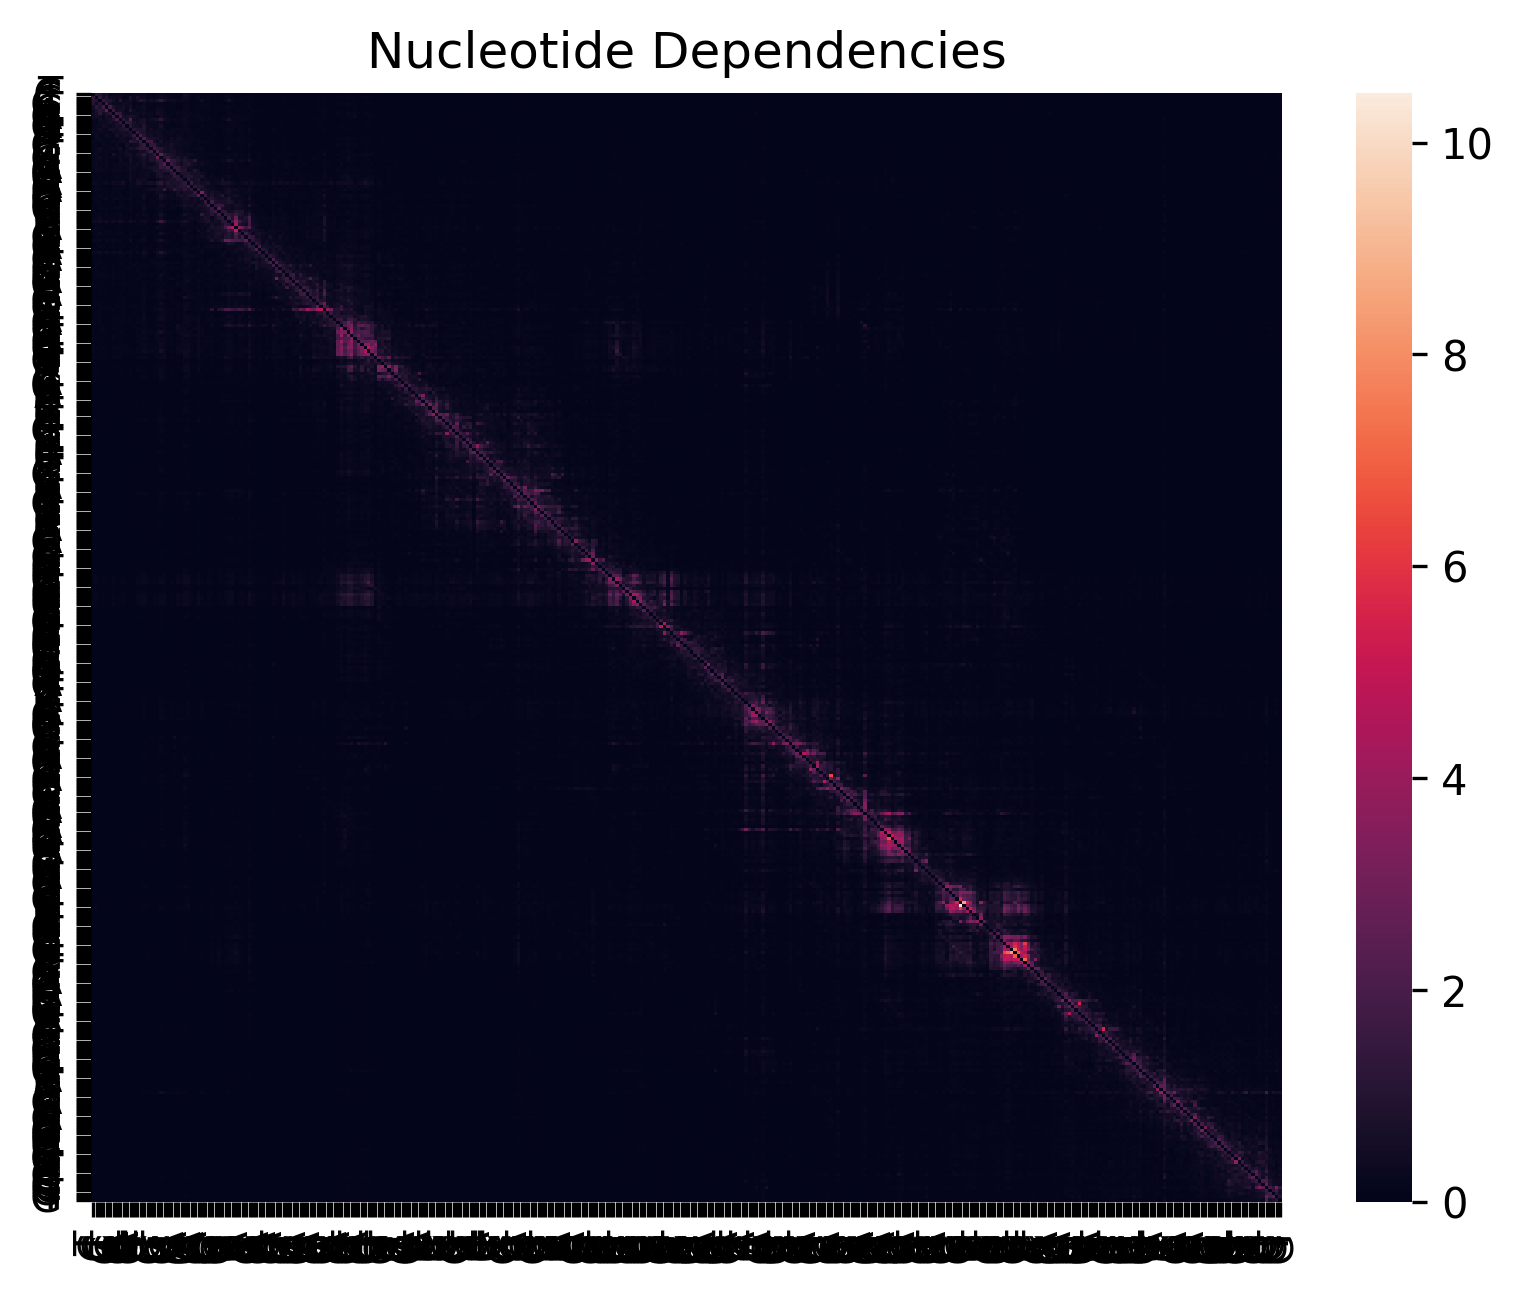

In [41]:
scores = run_dependency_pipeline(model, seq_tensor, 0)

# Plot Masked Predictions

This section plots masked probabilities across the region, which is very useful for detecting the motifs learned by the model in the sequence. Two plots are produced: one with only the true nucleotides in the sequence, and one with the probabilities for all four nucleotides. There are a couple of parameters which could aid visualization:

`limits`: an iterable of two values specifying the minimum and maximum y values. Example: `[0, 1.5]`

`demarcs`: an iterable of iterables, with each one containing start and end indices of desired parts of the sequence. Vertical lines will be drawn at each location specified, allowing the user to pinpoint specific regions of the overall sequence. Example: `[(130, 140), (300, 320)]`

tensor([[0.1143, 0.4302, 0.3162, 0.1395]], dtype=torch.float16)
torch.Size([1, 350, 4]) torch.Size([1, 4])
tensor([[0.0966, 0.3674, 0.4207, 0.1154]], dtype=torch.float16)
(1, 4, 350)


<Figure size 4800x2400 with 0 Axes>

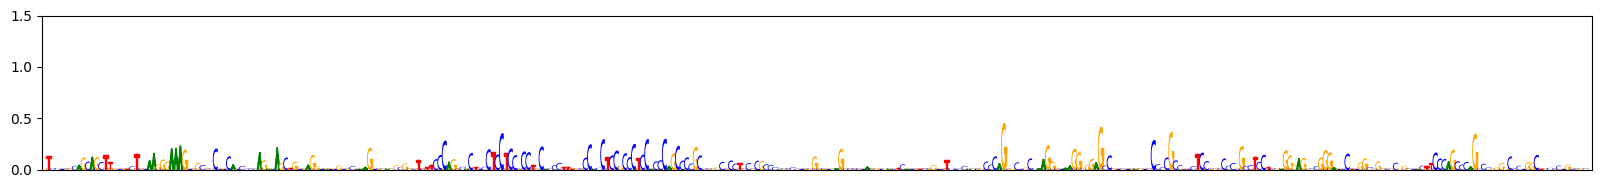

<Figure size 4800x2400 with 0 Axes>

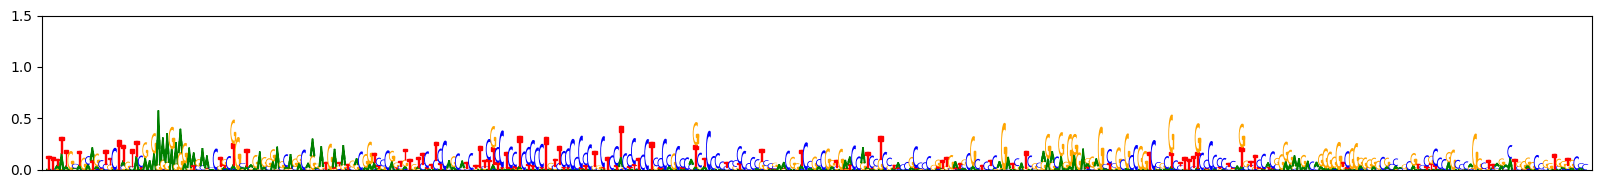

In [39]:
probs_norm = mask_and_predict(dna_seq, list(range(0, 350)), model)


# Plot Unmasked Predictions

This section plots unmasked probabilities across the region. The `limits` and `demarcs` parameters are the same as before. 

(1, 4, 350) (1, 4, 350)


<Figure size 4800x2400 with 0 Axes>

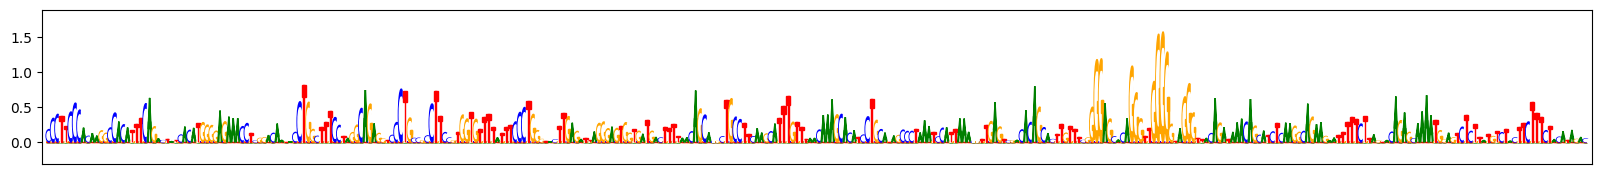

<Figure size 4800x2400 with 0 Axes>

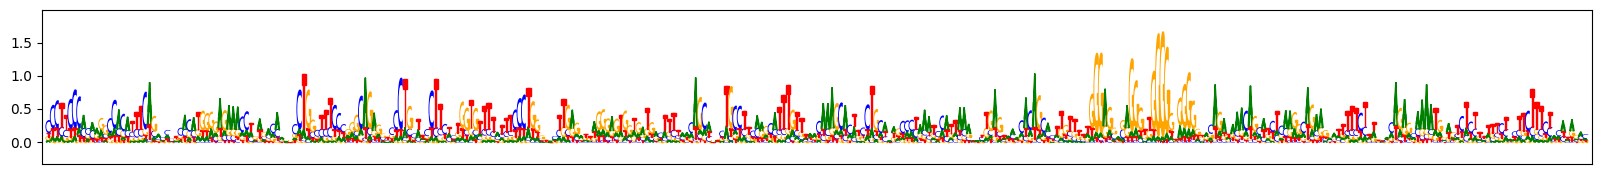

In [240]:
probs_norm = predict_no_mask(dna_seq, model)
